In [ ]:
# 05e: CIP embedding quality evaluation
# Intrinsic metrics for Node2Vec + Poincaré embeddings

!pip install numpy pandas scipy scikit-learn umap-learn

import numpy as np
import pandas as pd
import os

from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances
import umap

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

PROJ = "/content/drive/MyDrive/dissertation"

# Adjust these if needed based on where 05c/05d saved outputs
EMB_DIR = f"{PROJ}/outputs/embeddings_cip"
OUT_DIR = f"{PROJ}/outputs/embedding_quality_5e"

os.makedirs(OUT_DIR, exist_ok=True)

print("PROJECT:", PROJ)
print("EMB_DIR:", EMB_DIR)
print("OUT_DIR:", OUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT: /content/drive/MyDrive/dissertation
EMB_DIR: /content/drive/MyDrive/dissertation/outputs/embeddings_cip
OUT_DIR: /content/drive/MyDrive/dissertation/outputs/embedding_quality_5e


In [ ]:
# Filenames for CIP embeddings
NODE2VEC_FILE = f"{PROJ}/outputs/embeddings/cip_embeddings_graph_64.csv"
POINCARE_FILE = f"{PROJ}/outputs/embeddings/cip_embeddings_poincare_ipeds_64.csv"

def load_embedding(path: str) -> pd.DataFrame:
    """Load an embedding CSV and return a DataFrame indexed by code/token."""
    df = pd.read_csv(path)
    # Try to infer the ID column
    if "code" in df.columns:
        id_col = "code"
    elif "token" in df.columns:
        id_col = "token"
    else:
        id_col = df.columns[0]  # assume first col is the ID
    df[id_col] = df[id_col].astype(str).str.strip()
    df = df.set_index(id_col)
    return df

E_n2v = load_embedding(NODE2VEC_FILE)
E_poin = load_embedding(POINCARE_FILE)

print("Node2Vec shape:", E_n2v.shape)
print("Poincaré shape:", E_poin.shape)

print("\nNode2Vec head:")
display(E_n2v.head())
print("\nPoincaré head:")
display(E_poin.head())


Node2Vec shape: (1585, 64)
Poincaré shape: (1574, 64)

Node2Vec head:


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
cip,,,,,,,,,,,,,,,,,,,,,
45.1001,0.175457,-0.163499,0.081543,0.132906,-0.012698,-0.160591,0.075328,-0.178769,-0.129021,0.067863,...,0.056500,-0.116326,0.080240,-0.144570,-0.177305,0.201340,-0.083285,-0.105705,0.025078,-0.040732
38.0101,0.194948,-0.175086,-0.034399,0.131991,-0.024849,-0.064553,0.002092,-0.154861,-0.129862,0.031149,...,-0.011082,0.000113,0.115436,-0.211784,-0.144867,0.060004,0.011364,-0.101752,0.180900,-0.053448
40.0801,0.225312,-0.074358,0.002041,0.046958,0.044317,-0.136468,0.040754,-0.247589,-0.051645,0.124429,...,0.031199,-0.020668,0.145756,-0.174186,-0.193057,0.095246,-0.015475,-0.075143,0.060219,-0.008833
52.0201,0.226452,-0.177377,-0.044606,0.076762,0.061169,-0.158346,0.004388,-0.227178,-0.116700,0.055827,...,0.056166,-0.042559,0.042718,-0.223725,-0.148300,0.144098,-0.100957,-0.161234,0.023200,-0.118456
14.1901,0.184591,-0.188838,-0.009937,0.060270,0.091668,-0.118682,-0.005631,-0.182081,-0.147366,0.122613,...,0.078644,0.006334,0.069567,-0.214794,-0.111651,0.170695,-0.069840,-0.091317,0.127380,0.052038



Poincaré head:


,poinc_0,poinc_1,poinc_2,poinc_3,poinc_4,poinc_5,poinc_6,poinc_7,poinc_8,poinc_9,...,poinc_54,poinc_55,poinc_56,poinc_57,poinc_58,poinc_59,poinc_60,poinc_61,poinc_62,poinc_63
cip,,,,,,,,,,,,,,,,,,,,,
1.0,0.090471,0.197550,0.043015,-0.056116,-0.061400,-0.038373,0.075201,0.093177,0.168469,-0.038778,...,0.187417,0.125314,0.042074,-0.136623,-0.036190,0.069549,-0.049810,-0.101078,0.209098,-0.066828
1.0101,0.147367,0.201431,0.071400,-0.046829,-0.017985,-0.110639,0.071759,0.137153,0.179083,0.014359,...,0.141914,0.106939,0.111453,-0.115059,-0.028334,0.077553,0.050344,-0.139364,0.199735,-0.055682
1.0102,0.133944,0.199155,-0.000136,-0.014325,0.008370,-0.040488,0.082161,0.140083,0.152745,-0.035454,...,0.143322,0.130878,0.138846,-0.104361,0.011743,0.016922,-0.028874,-0.106440,0.204865,-0.071772
1.0103,0.051900,0.203464,0.013503,0.000496,-0.079537,-0.097635,0.053124,0.120365,0.162752,-0.028702,...,0.155462,0.114426,0.127033,-0.117831,0.025497,0.046080,-0.035165,-0.079472,0.187237,-0.050682
1.0104,0.069693,0.196363,0.075168,-0.048550,-0.027041,-0.113763,0.057446,0.139221,0.204076,-0.042833,...,0.096767,0.104519,0.160370,-0.114698,-0.006529,0.062369,-0.042677,-0.057034,0.212512,0.003987


In [ ]:
E_n2v = load_embedding(NODE2VEC_FILE)
E_poin = load_embedding(POINCARE_FILE)

# 🔧 NEW: ensure one row per CIP code
E_n2v = E_n2v[~E_n2v.index.duplicated(keep="first")]
E_poin = E_poin[~E_poin.index.duplicated(keep="first")]

print("Node2Vec shape after de-dup:", E_n2v.shape)
print("Poincaré shape after de-dup:", E_poin.shape)


Node2Vec shape after de-dup: (1575, 64)
Poincaré shape after de-dup: (1574, 64)


In [ ]:
# 1. Intersection of codes present in both embeddings
codes_n2v = set(E_n2v.index)
codes_poin = set(E_poin.index)
common = sorted(codes_n2v & codes_poin)

print("Codes in Node2Vec:", len(codes_n2v))
print("Codes in Poincaré:", len(codes_poin))
print("Intersection:", len(common))

def parse_cip_levels(code_str: str):
    """
    Parse L2, L4, L6 from a CIP string.
    Example: '51.0201' -> L2='51', L4='51.02', L6='51.0201'
    If format is weird (no '.'), use the raw as all three.
    """
    s = str(code_str).strip()
    if "." not in s:
        return s, s, s

    prefix, suffix = s.split(".", 1)
    prefix = prefix.strip()
    suffix = suffix.strip().replace(" ", "")

    # L2: top-level 2-digit area
    L2 = prefix

    # L4: prefix + '.' + first 2 of suffix
    if len(suffix) >= 2:
        L4 = f"{prefix}.{suffix[:2]}"
    else:
        L4 = f"{prefix}.{suffix:0<2}"

    # L6: prefix + '.' + first 4 of suffix
    if len(suffix) >= 4:
        L6 = f"{prefix}.{suffix[:4]}"
    else:
        L6 = f"{prefix}.{suffix:0<4}"

    return L2, L4, L6

# 2. Build taxonomy from codes
rows = []
for c in common:
    L2, L4, L6 = parse_cip_levels(c)
    rows.append({"code": c, "L2": L2, "L4": L4, "L6": L6})

taxonomy = pd.DataFrame(rows).reset_index(drop=True)
print("\nParsed taxonomy head:")
display(taxonomy.head())

# 3. Reorder embeddings to match taxonomy
E_n2v_aligned = E_n2v.loc[taxonomy["code"]].reset_index()
E_poin_aligned = E_poin.loc[taxonomy["code"]].reset_index()

E_n2v_aligned.rename(columns={E_n2v_aligned.columns[0]: "code"}, inplace=True)
E_poin_aligned.rename(columns={E_poin_aligned.columns[0]: "code"}, inplace=True)

print("\nAligned shapes:")
print("Node2Vec:", E_n2v_aligned.shape)
print("Poincaré:", E_poin_aligned.shape)


Codes in Node2Vec: 1575
Codes in Poincaré: 1574
Intersection: 1574

Parsed taxonomy head:


,code,L2,L4,L6
0,1.0,1,1.00,1.0000
1,1.0101,1,1.01,1.0101
2,1.0102,1,1.01,1.0102
3,1.0103,1,1.01,1.0103
4,1.0104,1,1.01,1.0104



Aligned shapes:
Node2Vec: (1574, 65)
Poincaré: (1574, 65)


In [ ]:
def cip_hierarchy_distance_matrix(tax_df: pd.DataFrame) -> np.ndarray:
    """
    Hierarchy distance:
      0 if same code (L6)
      1 if same L4 (different L6)
      2 if same L2 (different L4)
      3 otherwise
    """
    n = len(tax_df)
    D = np.zeros((n, n), dtype=float)

    codes = tax_df["code"].values
    L2 = tax_df["L2"].values
    L4 = tax_df["L4"].values

    for i in range(n):
        for j in range(n):
            if codes[i] == codes[j]:
                D[i, j] = 0.0
            elif L4[i] == L4[j]:
                D[i, j] = 1.0
            elif L2[i] == L2[j]:
                D[i, j] = 2.0
            else:
                D[i, j] = 3.0
    return D

D_tax = cip_hierarchy_distance_matrix(taxonomy)
D_tax.shape


(1574, 1574)

In [ ]:
def embedding_distance_matrix(E_aligned: pd.DataFrame) -> np.ndarray:
    X = E_aligned.drop(columns=["code"]).values
    D = cosine_distances(X)
    return D

D_n2v = embedding_distance_matrix(E_n2v_aligned)
D_poin = embedding_distance_matrix(E_poin_aligned)

D_n2v.shape, D_poin.shape


((1574, 1574), (1574, 1574))

In [ ]:
def idpe_score(D_tax: np.ndarray, D_emb: np.ndarray) -> float:
    idx = np.triu_indices_from(D_tax, k=1)
    tax_flat = D_tax[idx]
    emb_flat = D_emb[idx]
    rho, p = spearmanr(tax_flat, emb_flat)
    return float(rho)

idpe_n2v = idpe_score(D_tax, D_n2v)
idpe_poin = idpe_score(D_tax, D_poin)

print("IDPE (Node2Vec):", idpe_n2v)
print("IDPE (Poincaré):", idpe_poin)


IDPE (Node2Vec): 0.04846694556798938
IDPE (Poincaré): 0.38384145879538806


In [ ]:
from tqdm import tqdm

def precision_at_k(E_aligned: pd.DataFrame, tax_df: pd.DataFrame, k=10):
    X = E_aligned.drop(columns=["code"]).values
    nbrs = NearestNeighbors(n_neighbors=k+1, metric="cosine").fit(X)
    distances, indices = nbrs.kneighbors(X)

    L2 = tax_df["L2"].values
    L4 = tax_df["L4"].values

    precisions_L2 = []
    precisions_L4 = []

    for i in range(len(X)):
        neigh_idx = indices[i][1:]  # skip self
        neigh_L2 = L2[neigh_idx]
        neigh_L4 = L4[neigh_idx]

        true_L2 = L2[i]
        true_L4 = L4[i]

        p_L2 = np.mean(neigh_L2 == true_L2)
        p_L4 = np.mean(neigh_L4 == true_L4)

        precisions_L2.append(p_L2)
        precisions_L4.append(p_L4)

    return float(np.mean(precisions_L2)), float(np.mean(precisions_L4))

pL2_n2v, pL4_n2v = precision_at_k(E_n2v_aligned, taxonomy, k=10)
pL2_poin, pL4_poin = precision_at_k(E_poin_aligned, taxonomy, k=10)

print("Node2Vec P@10 L2:", pL2_n2v, "L4:", pL4_n2v)
print("Poincaré P@10 L2:", pL2_poin, "L4:", pL4_poin)


Node2Vec P@10 L2: 0.07687420584498093 L4: 0.011118170266836086
Poincaré P@10 L2: 0.8128335451080051 L4: 0.10412960609911055


In [ ]:
def pca_complexity(E_aligned: pd.DataFrame, n_components=10):
    X = E_aligned.drop(columns=["code"]).values
    pca = PCA(n_components=n_components, random_state=42).fit(X)
    return pca.explained_variance_ratio_

pca_n2v = pca_complexity(E_n2v_aligned, n_components=10)
pca_poin = pca_complexity(E_poin_aligned, n_components=10)

print("Node2Vec PCA variance ratio (first 10 PCs):")
print(pca_n2v)

print("\nPoincaré PCA variance ratio (first 10 PCs):")
print(pca_poin)


Node2Vec PCA variance ratio (first 10 PCs):
[0.54427724 0.07289274 0.01494672 0.01417867 0.01350473 0.012589
 0.01236239 0.01211001 0.01076645 0.01028417]

Poincaré PCA variance ratio (first 10 PCs):
[0.21571524 0.08312174 0.07265804 0.06199476 0.04608937 0.04463425
 0.0379242  0.02314184 0.02191829 0.01791065]


In [ ]:
def nn_overlap(E1: pd.DataFrame, E2: pd.DataFrame, k=10) -> float:
    X1 = E1.drop(columns=["code"]).values
    X2 = E2.drop(columns=["code"]).values

    nbrs1 = NearestNeighbors(n_neighbors=k+1, metric="cosine").fit(X1)
    nbrs2 = NearestNeighbors(n_neighbors=k+1, metric="cosine").fit(X2)

    _, idx1 = nbrs1.kneighbors(X1)
    _, idx2 = nbrs2.kneighbors(X2)

    overlaps = []
    for i in range(len(X1)):
        nn1 = set(idx1[i][1:])
        nn2 = set(idx2[i][1:])
        if k > 0:
            overlaps.append(len(nn1 & nn2) / k)

    return float(np.mean(overlaps))

overlap_n2v_poin = nn_overlap(E_n2v_aligned, E_poin_aligned, k=10)
print("NN overlap (Node2Vec vs Poincaré, k=10):", overlap_n2v_poin)


NN overlap (Node2Vec vs Poincaré, k=10): 0.01048284625158831


In [ ]:
def silhouette_by_level(E_aligned: pd.DataFrame, tax_df: pd.DataFrame, level: str):
    X = E_aligned.drop(columns=["code"]).values
    labels = tax_df[level].values
    if len(np.unique(labels)) < 2:
        return np.nan
    return float(silhouette_score(X, labels, metric="cosine"))

sil_L2_n2v = silhouette_by_level(E_n2v_aligned, taxonomy, "L2")
sil_L4_n2v = silhouette_by_level(E_n2v_aligned, taxonomy, "L4")

sil_L2_poin = silhouette_by_level(E_poin_aligned, taxonomy, "L2")
sil_L4_poin = silhouette_by_level(E_poin_aligned, taxonomy, "L4")

print("Node2Vec silhouette L2:", sil_L2_n2v, "L4:", sil_L4_n2v)
print("Poincaré silhouette L2:", sil_L2_poin, "L4:", sil_L4_poin)


Node2Vec silhouette L2: -0.33907499666627056 L4: -0.50454093436936
Poincaré silhouette L2: 0.5398201724684059 L4: -0.2529346799373518


In [ ]:
results = []

def add(method, metric, value):
    results.append({"Method": method, "Metric": metric, "Value": value})

# Node2Vec
add("Node2Vec", "IDPE", idpe_n2v)
add("Node2Vec", "P@10_L2", pL2_n2v)
add("Node2Vec", "P@10_L4", pL4_n2v)
add("Node2Vec", "Sil_L2", sil_L2_n2v)
add("Node2Vec", "Sil_L4", sil_L4_n2v)
for i, v in enumerate(pca_n2v, start=1):
    add("Node2Vec", f"PCA_var_PC{i}", v)

# Poincaré
add("Poincaré", "IDPE", idpe_poin)
add("Poincaré", "P@10_L2", pL2_poin)
add("Poincaré", "P@10_L4", pL4_poin)
add("Poincaré", "Sil_L2", sil_L2_poin)
add("Poincaré", "Sil_L4", sil_L4_poin)
for i, v in enumerate(pca_poin, start=1):
    add("Poincaré", f"PCA_var_PC{i}", v)

df_results = pd.DataFrame(results)
out_path = f"{OUT_DIR}/embedding_quality_cip_node2vec_poincare.csv"
df_results.to_csv(out_path, index=False)

print("Saved metrics to:", out_path)
df_results.head(20)


Saved metrics to: /content/drive/MyDrive/dissertation/outputs/embedding_quality_5e/embedding_quality_cip_node2vec_poincare.csv


,Method,Metric,Value
0,Node2Vec,IDPE,0.048467
1,Node2Vec,P@10_L2,0.076874
2,Node2Vec,P@10_L4,0.011118
3,Node2Vec,Sil_L2,-0.339075
4,Node2Vec,Sil_L4,-0.504541
5,Node2Vec,PCA_var_PC1,0.544277
6,Node2Vec,PCA_var_PC2,0.072893
7,Node2Vec,PCA_var_PC3,0.014947
8,Node2Vec,PCA_var_PC4,0.014179
9,Node2Vec,PCA_var_PC5,0.013505


In [ ]:
# Optional qualitative 2D visualization via UMAP

umap_model = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

X_n2v = E_n2v_aligned.drop(columns=["code"]).values
X_poin = E_poin_aligned.drop(columns=["code"]).values
L2_labels = taxonomy["L2"].values

X_n2v_2d = umap_model.fit_transform(X_n2v)
X_poin_2d = umap_model.fit_transform(X_poin)

umap_df_n2v = pd.DataFrame({
    "UMAP1": X_n2v_2d[:, 0],
    "UMAP2": X_n2v_2d[:, 1],
    "L2": L2_labels,
    "code": taxonomy["code"].values
})

umap_df_poin = pd.DataFrame({
    "UMAP1": X_poin_2d[:, 0],
    "UMAP2": X_poin_2d[:, 1],
    "L2": L2_labels,
    "code": taxonomy["code"].values
})

umap_df_n2v.to_csv(f"{OUT_DIR}/umap_node2vec_L2.csv", index=False)
umap_df_poin.to_csv(f"{OUT_DIR}/umap_poincare_L2.csv", index=False)

print("Saved UMAP projections to:")
print(f"  {OUT_DIR}/umap_node2vec_L2.csv")
print(f"  {OUT_DIR}/umap_poincare_L2.csv")


Saved UMAP projections to:
  /content/drive/MyDrive/dissertation/outputs/embedding_quality_5e/umap_node2vec_L2.csv
  /content/drive/MyDrive/dissertation/outputs/embedding_quality_5e/umap_poincare_L2.csv


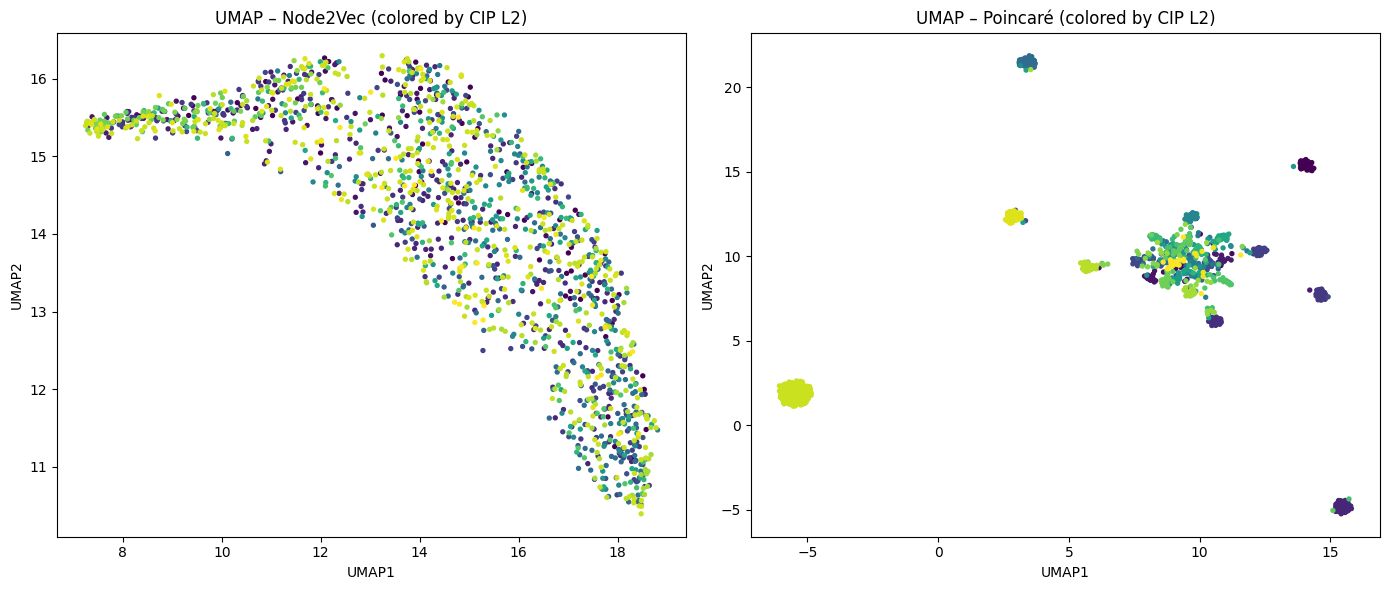

In [ ]:
# In-notebook visualization of UMAP projections for Node2Vec and Poincaré

import matplotlib.pyplot as plt

def l2_to_int(labels):
    uniq = sorted(pd.unique(labels))
    mapping = {v: i for i, v in enumerate(uniq)}
    return [mapping[x] for x in labels]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Node2Vec ---
ax = axes[0]
c = l2_to_int(umap_df_n2v["L2"].values)
ax.scatter(
    umap_df_n2v["UMAP1"],
    umap_df_n2v["UMAP2"],
    c=c,
    s=8
)
ax.set_title("UMAP – Node2Vec (colored by CIP L2)")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

# --- Poincaré ---
ax = axes[1]
c = l2_to_int(umap_df_poin["L2"].values)
ax.scatter(
    umap_df_poin["UMAP1"],
    umap_df_poin["UMAP2"],
    c=c,
    s=8
)
ax.set_title("UMAP – Poincaré (colored by CIP L2)")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

plt.tight_layout()
plt.show()


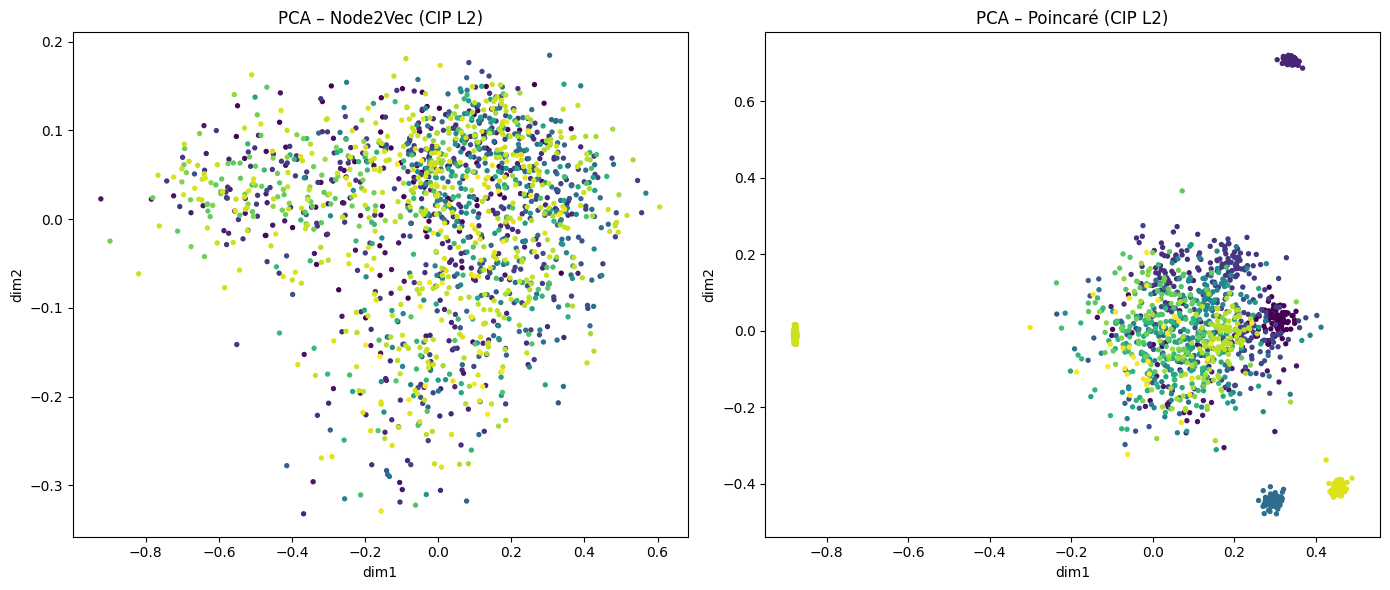

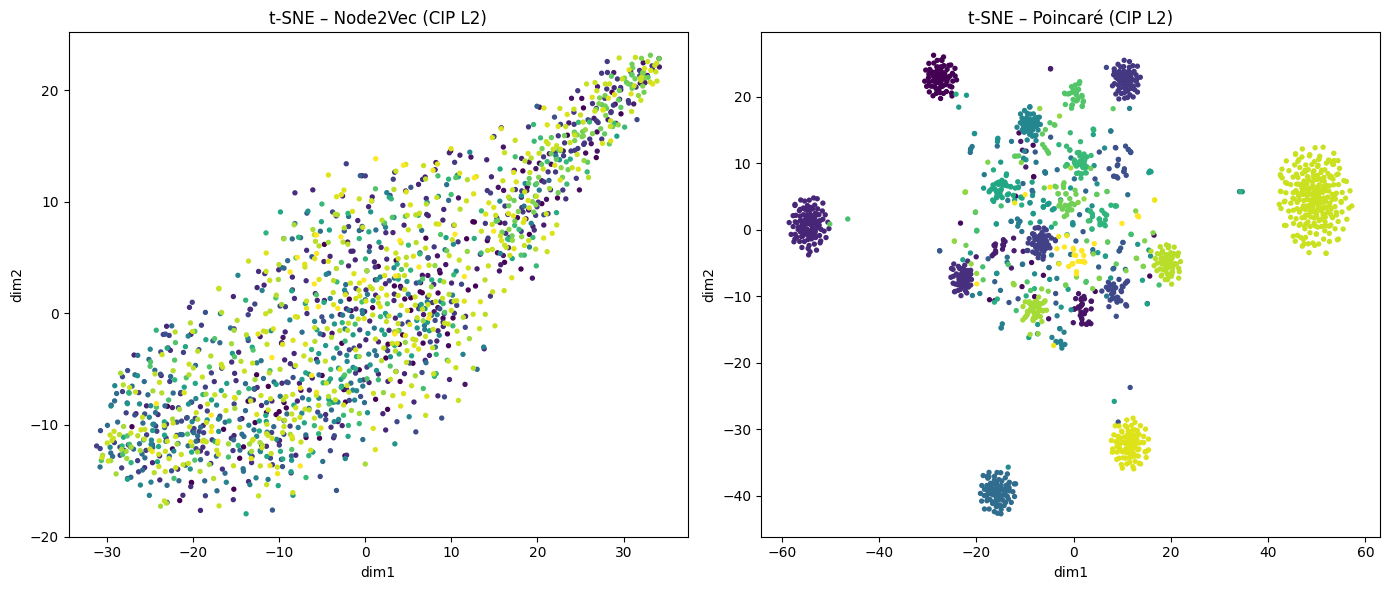

In [ ]:
# Additional visualizations for consistency: PCA + t-SNE

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_scatter(df, title, axes):
    def l2_to_int(labels):
        uniq = sorted(pd.unique(labels))
        mapping = {v: i for i, v in enumerate(uniq)}
        return [mapping[x] for x in labels]

    c = l2_to_int(df["L2"])
    axes.scatter(df["dim1"], df["dim2"], c=c, s=8)
    axes.set_title(title)
    axes.set_xlabel("dim1")
    axes.set_ylabel("dim2")

# ----------------------------------------------------
# 1. PCA 2D Projections
# ----------------------------------------------------
pca = PCA(n_components=2)

# Node2Vec PCA
pca_n2v = pca.fit_transform(X_n2v)
df_pca_n2v = pd.DataFrame({"dim1": pca_n2v[:,0],
                           "dim2": pca_n2v[:,1],
                           "L2": L2_labels})

# Poincaré PCA
pca_poin = pca.fit_transform(X_poin)
df_pca_poin = pd.DataFrame({"dim1": pca_poin[:,0],
                            "dim2": pca_poin[:,1],
                            "L2": L2_labels})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_scatter(df_pca_n2v, "PCA – Node2Vec (CIP L2)", axes[0])
plot_scatter(df_pca_poin, "PCA – Poincaré (CIP L2)", axes[1])
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 2. t-SNE 2D Projections
# ----------------------------------------------------
tsne = TSNE(n_components=2, perplexity=30, init="pca", random_state=42, learning_rate=200)

# Node2Vec t-SNE
tsne_n2v = tsne.fit_transform(X_n2v)
df_tsne_n2v = pd.DataFrame({"dim1": tsne_n2v[:,0],
                            "dim2": tsne_n2v[:,1],
                            "L2": L2_labels})

# Poincaré t-SNE
tsne_poin = tsne.fit_transform(X_poin)
df_tsne_poin = pd.DataFrame({"dim1": tsne_poin[:,0],
                             "dim2": tsne_poin[:,1],
                             "L2": L2_labels})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_scatter(df_tsne_n2v, "t-SNE – Node2Vec (CIP L2)", axes[0])
plot_scatter(df_tsne_poin, "t-SNE – Poincaré (CIP L2)", axes[1])
plt.tight_layout()
plt.show()


Saved PCA CSVs:
  /content/drive/MyDrive/dissertation/outputs/embedding_quality_5e/pca_node2vec_L2.csv
  /content/drive/MyDrive/dissertation/outputs/embedding_quality_5e/pca_poincare_L2.csv


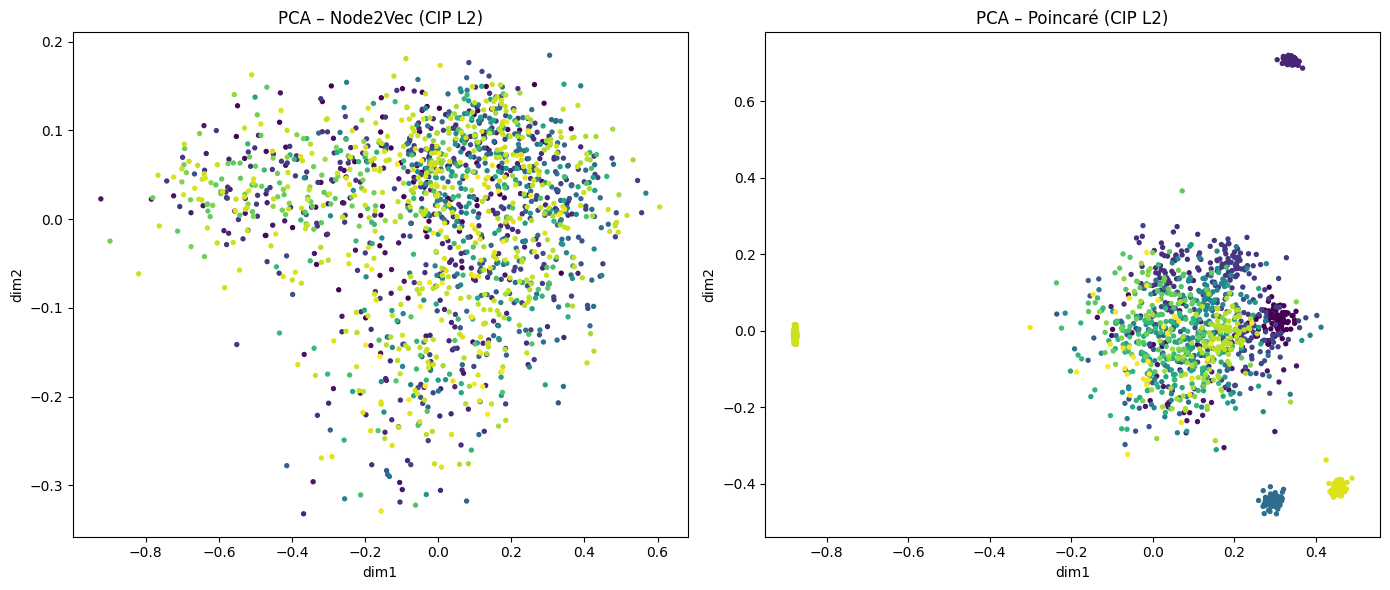

Saved t-SNE CSVs:
  /content/drive/MyDrive/dissertation/outputs/embedding_quality_5e/tsne_node2vec_L2.csv
  /content/drive/MyDrive/dissertation/outputs/embedding_quality_5e/tsne_poincare_L2.csv


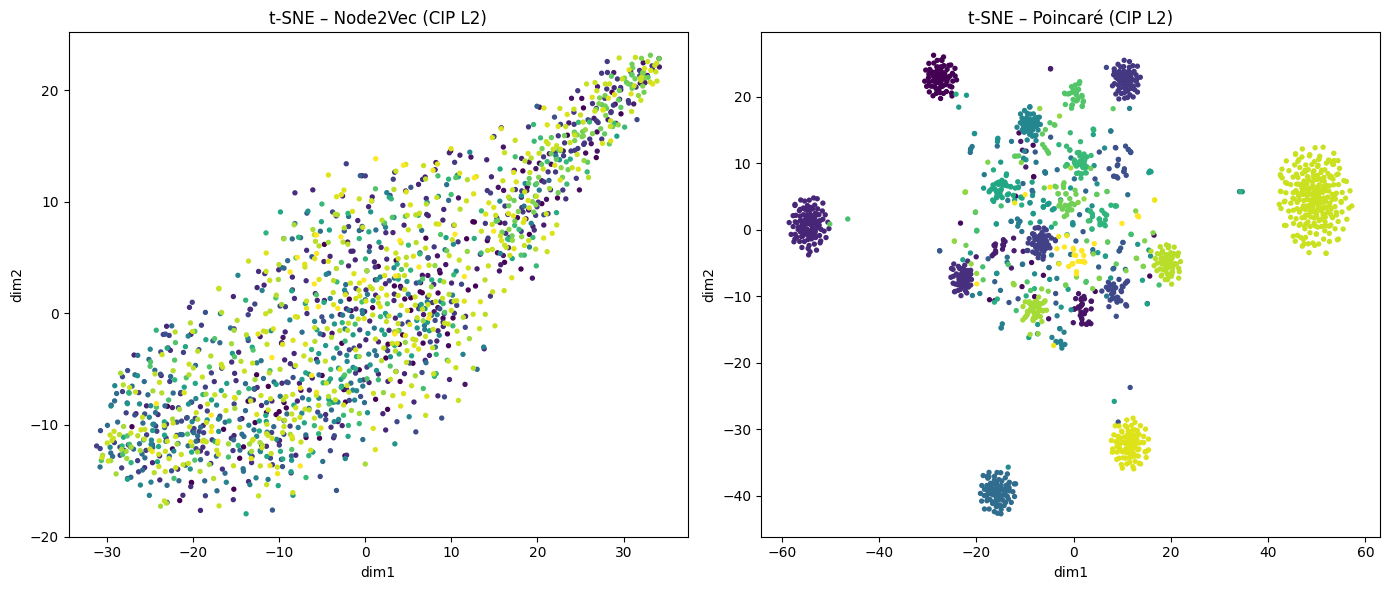

In [ ]:
# ===============================================================
# Additional Visualizations: PCA + t-SNE + Saving to OUT_DIR
# ===============================================================

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_scatter(df, title, ax):
    def l2_to_int(labels):
        uniq = sorted(pd.unique(labels))
        mapping = {v: i for i, v in enumerate(uniq)}
        return [mapping[x] for x in labels]
    colors = l2_to_int(df["L2"])
    ax.scatter(df["dim1"], df["dim2"], c=colors, s=8)
    ax.set_title(title)
    ax.set_xlabel("dim1")
    ax.set_ylabel("dim2")


# ===============================================================
# 1. PCA 2D
# ===============================================================
pca = PCA(n_components=2)

pca_n2v = pca.fit_transform(X_n2v)
pca_poin = pca.fit_transform(X_poin)

df_pca_n2v = pd.DataFrame({"dim1": pca_n2v[:,0],
                           "dim2": pca_n2v[:,1],
                           "L2": L2_labels,
                           "code": taxonomy["code"].values})

df_pca_poin = pd.DataFrame({"dim1": pca_poin[:,0],
                            "dim2": pca_poin[:,1],
                            "L2": L2_labels,
                            "code": taxonomy["code"].values})

# Save
df_pca_n2v.to_csv(f"{OUT_DIR}/pca_node2vec_L2.csv", index=False)
df_pca_poin.to_csv(f"{OUT_DIR}/pca_poincare_L2.csv", index=False)

print(f"Saved PCA CSVs:")
print(f"  {OUT_DIR}/pca_node2vec_L2.csv")
print(f"  {OUT_DIR}/pca_poincare_L2.csv")


# Show PCA plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_scatter(df_pca_n2v, "PCA – Node2Vec (CIP L2)", axes[0])
plot_scatter(df_pca_poin, "PCA – Poincaré (CIP L2)", axes[1])
plt.tight_layout()
plt.show()


# ===============================================================
# 2. t-SNE 2D
# ===============================================================
tsne = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    random_state=42,
    learning_rate=200,
    n_iter=1000
)

tsne_n2v = tsne.fit_transform(X_n2v)
tsne_poin = tsne.fit_transform(X_poin)

df_tsne_n2v = pd.DataFrame({"dim1": tsne_n2v[:,0],
                            "dim2": tsne_n2v[:,1],
                            "L2": L2_labels,
                            "code": taxonomy["code"].values})

df_tsne_poin = pd.DataFrame({"dim1": tsne_poin[:,0],
                             "dim2": tsne_poin[:,1],
                             "L2": L2_labels,
                             "code": taxonomy["code"].values})

# Save
df_tsne_n2v.to_csv(f"{OUT_DIR}/tsne_node2vec_L2.csv", index=False)
df_tsne_poin.to_csv(f"{OUT_DIR}/tsne_poincare_L2.csv", index=False)

print(f"Saved t-SNE CSVs:")
print(f"  {OUT_DIR}/tsne_node2vec_L2.csv")
print(f"  {OUT_DIR}/tsne_poincare_L2.csv")


# Show t-SNE plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_scatter(df_tsne_n2v, "t-SNE – Node2Vec (CIP L2)", axes[0])
plot_scatter(df_tsne_poin, "t-SNE – Poincaré (CIP L2)", axes[1])
plt.tight_layout()
plt.show()
